# Исследование рынка заведений общественного питания Москвы

Мы решили открыть небольшое кафе в Москве. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время?<br>
Партнёры просят нас подготовить исследование рынка - для этого у нас есть открытые данные о заведениях общественного питания в Москве.

**Цели исследования:**
1. Сделать общий вывод и дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения.
2. Рассмотреть возможность развития сети.
3. Подготовить презентацию исследования для инвесторов.

## Импорт и изучение данных

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format) # Вывод трех знаков после запятой
pd.options.display.max_colwidth = 100 # Максимальная ширина столбца таблицы
import seaborn as sns
sns.set(rc = {'figure.figsize':(10,5)}) # Размер диаграмм
from matplotlib import pyplot as plt
from io import BytesIO
import requests

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


**Описание данных:**
* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевой ресторан;
* `object_type` — тип объекта общественного питания;
* `address` — адрес;
* `number` — количество посадочных мест.

In [3]:
data.head(15)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120


In [4]:
data['object_name'] = data['object_name'].str.lower() # Названия объектов переводим в нижний регистр
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


Найдем все заведения, отмеченные как сетевые, но имеющие только 1 объект, и исправим это.

In [5]:
# Удаляем типы из названий
repl = ['кафе ', 'ресторан ', '«', '»']
for item in repl:
    data['object_name'] = data['object_name'].str.replace(item, '')

In [6]:
# Выделяем неправильные сетевые заведения
fake_chains = data.query('chain == "да"').groupby('object_name').agg({'object_type': 'count'}).query('object_type == 1').reset_index()
fake_chains.head(10)

,object_name,object_type
0,beverly hills diner,1
1,bierloga,1
2,black & white,1
3,boobo,1
4,bubbleology,1
5,coffeeshop,1
6,cookhouse,1
7,deli by prime прайм-кафе,1
8,fridays,1
9,fridays kfc,1


In [7]:
data.loc[data['object_name'].isin(fake_chains['object_name'].unique()), 'chain'] = 'нет'

## Анализ данных
### Виды объектов
В разделе исследуем следущие вопросы:
* Соотношение видов объектов общественного питания по количеству;
* Соотношение сетевых и несетевых заведений по количеству;
* Для какого вида объекта общественного питания характерно сетевое распространение.

chain,да,нет,всего,процент сетей
object_type,,,,
кафе,1275,4824,6099,20.91
столовая,3,2584,2587,0.12
ресторан,481,1804,2285,21.05
предприятие быстрого обслуживания,757,1166,1923,39.37
бар,20,836,856,2.34
буфет,11,574,585,1.88
кафетерий,46,352,398,11.56
закусочная,46,314,360,12.78
магазин (отдел кулинарии),73,200,273,26.74


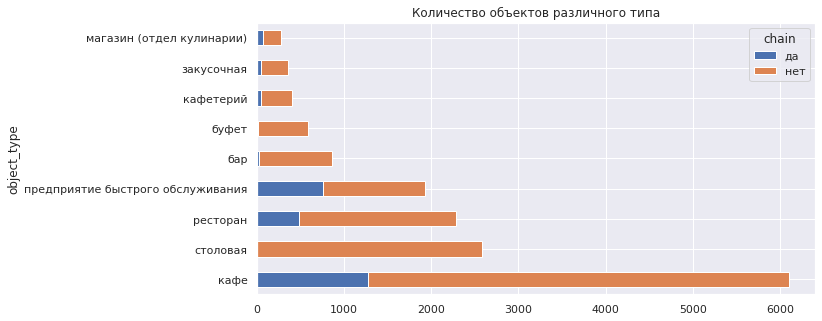

In [8]:
report = data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'nunique')
report['total'] = report['да'] + report['нет']
report['chain_perc'] = report['да'] / report['total'] * 100
report = report.sort_values(by = 'total', ascending = False).rename(columns = {'total': 'всего',
                                                                               'chain_perc': 'процент сетей'})
display(report)

report[['да', 'нет']].plot(kind = 'barh', stacked = True, title = 'Количество объектов различного типа', figsize = (10, 5))

По **соотношению видов объектов** можно выделить следующее:
* Наиболее популярный тип - **кафе** (6099 заведений);
* **Столовые**, **рестораны** и **предприятия быстрого обслуживания** представлены значительно меньшим количеством заведений - в диапазоне от 2000 до 2500 заведений;
* Наименее популярный тип - **магазин (отдел кулинарии)** - 273 заведения.

По **соотношению сетевых и несетевых заведений**:
* Самое большое количество сетевых заведений в категориях **предприятие быстрого обслуживания** (39.37%), **магазин (отдел кулинарии)** (26.74%) и **ресторан** (21.05%);
* Меньше всего сетевых заведений в категориях **бар** (2.34%), **буфет** (1.88%) и **столовая** (0.12%).

Наиболее часто сетевое распространение встречается в категории **предприятие быстрого обслуживания** (757 из 1923 заведений, 38.22%).

### Сетевые заведения
#### Общая характеристика
Исследуем, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

,Число сетей,Медианное число заведений,Медианное число посадочных мест
Группа,,,
Мало заведений - Мало мест,31,2,15.00
Мало заведений - Много мест,91,2,60.00
Много заведений - Мало мест,24,14,11.61
Много заведений - Много мест,69,10,58.17


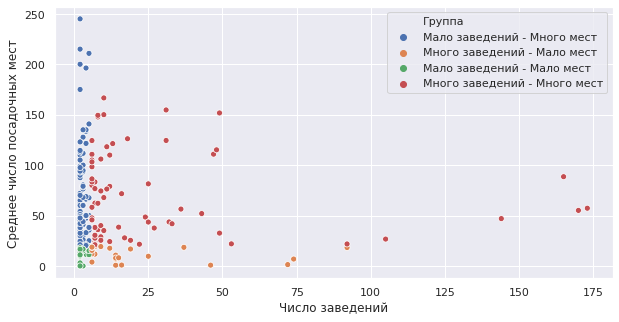

In [9]:
chains = data.query('chain == "да"').groupby('object_name').agg({'id': 'count', 'number': 'mean'})

# Присваиваем заведениям категории на основе количества заведений (>5)
chains['rest_count_group'] = 'Мало заведений'
chains.loc[chains['id'] > 5, 'rest_count_group'] = 'Много заведений'

# Присваиваем заведениям категории на основе количества посадочных мест (>20)
chains['seat_count_group'] = 'Мало мест'
chains.loc[chains['number'] > 20, 'seat_count_group'] = 'Много мест'

chains['Группа'] = chains['rest_count_group'].astype(str) + ' - ' + chains['seat_count_group'].astype(str)
sns.scatterplot(data = chains, x = 'id', y = 'number', hue = 'Группа')
plt.xlabel('Число заведений')
plt.ylabel('Среднее число посадочных мест')

chains.reset_index().groupby('Группа').agg({'object_name': 'nunique', 'id': 'median', 'number': 'median'})\
                                      .rename(columns = {'object_name': 'Число сетей',
                                                         'id': 'Медианное число заведений',
                                                         'number': 'Медианное число посадочных мест'})

По диаграмме видно, что большинство сетей имеет меньше 25 заведений с большим разбросом посадочных мест. В целом для них характерно большое количество посадочных мест (больше 20).

### Характеристика каждого вида объекта общественного питания
Для каждого вида объекта общественного питания опишем среднее количество посадочных мест.

,Тип заведения,Среднее число посадочных мест
8,столовая,130.25
7,ресторан,96.83
1,буфет,51.13
0,бар,43.49
3,кафе,39.72
6,предприятие быстрого обслуживания,20.55
4,кафетерий,9.12
2,закусочная,7.61
5,магазин (отдел кулинарии),5.59


Text(0.5, 1.0, 'Количество посадочных мест по типам заведения')

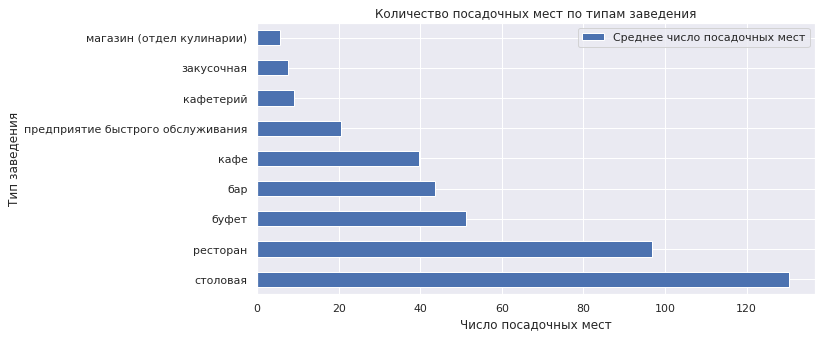

In [10]:
number_of_seats = data.pivot_table(index = 'object_type', values = 'number', aggfunc = 'mean').reset_index()\
                      .sort_values(by = 'number', ascending = False)\
                      .rename(columns = {'object_type': 'Тип заведения',
                                         'number': 'Среднее число посадочных мест'})
display(number_of_seats)

number_of_seats[['Тип заведения','Среднее число посадочных мест']].set_index('Тип заведения').plot(kind = 'barh', stacked = True)
plt.xlabel('Число посадочных мест')
plt.title('Количество посадочных мест по типам заведения')

Больше всего посадочных мест предоставляют **столовые** - в среднем 131. На втором месте - **рестораны** с 97ю посадочными местами.

### Изучение информации о расположении
Выделим в отдельный столбец информацию об улице, на которой расположено каждое заведение.

In [11]:
data['streetname'] = data['address'].apply(lambda x: x.split(',')[1])
data['streetname'] = data['streetname'].str.strip()
data[['object_name', 'address', 'streetname']].head(5)

,object_name,address,streetname
0,сметана,"город Москва, улица Егора Абакумова, дом 9",улица Егора Абакумова
1,родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",улица Талалихина
2,академия,"город Москва, Абельмановская улица, дом 6",Абельмановская улица
3,пиццетория,"город Москва, Абрамцевская улица, дом 1",Абрамцевская улица
4,вишневая метель,"город Москва, Абрамцевская улица, дом 9, корпус 1",Абрамцевская улица


#### Улицы с максимальным количеством заведений
Выделим топ-10 улиц по количеству объектов общественного питания:

In [12]:
top_10_streets = data.groupby('streetname')\
                     .agg({'id': 'count'})\
                     .sort_values(by = 'id', ascending = False)\
                     .reset_index()\
                     .rename(columns = {'id': 'Количество заведений'}).head(10)
top_10_streets

,streetname,Количество заведений
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,138
8,проспект Вернадского,132
9,Кутузовский проспект,114


Импортируем классификатор улиц с районами и соединяем с полученной выше таблицей:

In [13]:
spreadsheet_id = '1CrYdZ9tbYtqeFd22HHTD-wVIaM7YOviqtK9SAs9y58E'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
street_data = pd.read_csv(BytesIO(r.content))
street_data.head(10)

,streetname,okrug,area
0,Выставочный переулок,ЦАО,Пресненский район
1,улица Гашека,ЦАО,Пресненский район
2,Большая Никитская улица,ЦАО,Пресненский район
3,Глубокий переулок,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,ЦАО,Пресненский район
5,Малый Гнездниковский переулок,ЦАО,Пресненский район
6,Большая Грузинская улица,ЦАО,Пресненский район
7,Малая Грузинская улица,ЦАО,Пресненский район
8,Грузинская площадь,ЦАО,Пресненский район
9,улица Грузинский Вал,ЦАО,Пресненский район


In [14]:
top_10_merged = top_10_streets.merge(street_data, on = 'streetname', how = 'left')
top_10_merged['okrug'] = top_10_merged['okrug'].fillna('НАО')
top_10_merged['area'] = top_10_merged['area'].fillna('Поселение Сосенское')
display(top_10_merged)
print('Список районов, в которых находятся улицы из списка топ-10:', top_10_merged['area'].unique())

,streetname,Количество заведений,okrug,area
0,город Зеленоград,232,Зеленоград,Район Крюково
1,город Зеленоград,232,Зеленоград,Район Матушкино-Савелки
2,город Зеленоград,232,Зеленоград,Панфиловский район
3,проспект Мира,204,СВАО,Алексеевский район
4,проспект Мира,204,СВАО,Ярославский Район
5,проспект Мира,204,СВАО,Район Марьина роща
6,проспект Мира,204,СВАО,Останкинский район
7,проспект Мира,204,СВАО,Район Ростокино
8,проспект Мира,204,СВАО,Район Свиблово
9,проспект Мира,204,ЦАО,Мещанский район


Список районов, в которых находятся улицы из списка топ-10: ['Район Крюково' 'Район Матушкино-Савелки' 'Панфиловский район'
 'Алексеевский район' 'Ярославский Район' 'Район Марьина роща'
 'Останкинский район' 'Район Ростокино' 'Район Свиблово' 'Мещанский район'
 'Академический район' 'Район Черемушки' 'Район Ясенево' 'Район Коньково'
 'Обручевский район' 'Район Теплый Стан' 'Район Аэропорт' 'Район Беговой'
 'Хорошевский район' 'Район Сокол' 'Пресненский район'
 'Район Чертаново Центральное' 'Район Чертаново Северное'
 'Район Чертаново Южное' 'Донской район' 'Район Нагатино-Садовники'
 'Нагорный район' 'Район Северное Бутово' 'Район Южное Бутово'
 'Район Проспект Вернадского' 'Район Тропарево-Никулино'
 'Район Гагаринский' 'Ломоносовский район' 'Район Якиманка'
 'Поселение Сосенское' 'Район Раменки' 'Район Дорогомилово'
 'Район Фили-Давыдково']


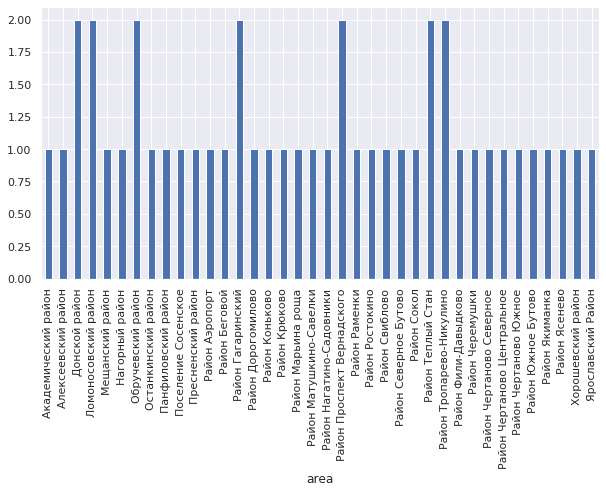

In [15]:
plt.xlabel = 'Количество улиц'
plt.ylabel = 'Район'
top_10_merged.groupby('area').agg({'streetname': 'count'}).plot(kind = 'bar', legend = False)

Видно, что только в нескольких районах есть больше одной улицы из списка топ-10 популярных.

#### Улицы с одним заведений
По аналогии с предыдущим пунктом выделим улицы с одним объектом общественного питания и районы, где эти улицы находятся.

In [16]:
one_shop_str = data.groupby('streetname').agg({'id': 'count'}).query('id == 1')\
                     .reset_index().rename(columns = {'id': 'Количество заведений'})
one_shop_str_merged = one_shop_str.merge(street_data, on = 'streetname', how = 'left')
display(one_shop_str_merged.head(10))
print('Список районов, в которых находятся улицы с одним заведением:', one_shop_str_merged['area'].unique())

,streetname,Количество заведений,okrug,area
0,1-й Балтийский переулок,1,САО,Район Аэропорт
1,1-й Басманный переулок,1,ЦАО,Басманный район
2,1-й Басманный переулок,1,ЦАО,Красносельский район
3,1-й Ботанический проезд,1,СВАО,Район Свиблово
4,1-й Вешняковский проезд,1,ЮВАО,Рязанский район
5,1-й Голутвинский переулок,1,ЦАО,Район Якиманка
6,1-й Зачатьевский переулок,1,ЦАО,Район Хамовники
7,1-й Кирпичный переулок,1,ВАО,Район Соколиная Гора
8,1-й Кожевнический переулок,1,ЮАО,Даниловский район
9,1-й Кожуховский проезд,1,ЮАО,Даниловский район


Список районов, в которых находятся улицы с одним заведением: ['Район Аэропорт' 'Басманный район' 'Красносельский район'
 'Район Свиблово' 'Рязанский район' 'Район Якиманка' 'Район Хамовники'
 'Район Соколиная Гора' 'Даниловский район' 'Мещанский район'
 'Таганский район' 'Район Лефортово' 'Район Печатники' 'Район Сокольники'
 'Район Замоскворечье' 'Хорошевский район' 'Район Арбат'
 'Алексеевский район' 'Район Текстильщики' 'Район Ростокино'
 'Район Раменки' 'Район Хорошево-Мневники' 'Район Покровское-Стрешнево'
 'Район Марьина роща' 'Район Богородское' 'Нижегородский район'
 'Тверской район' 'Лосиноостровский район' 'Район Преображенское'
 'Район Ново-Переделкино' nan 'Район Измайлово' 'Район Северное Измайлово'
 'Район Восточное Измайлово' 'Район Беговой' 'Донской район'
 'Район Гольяново' 'Войковский Район' 'Савеловский район'
 'Район Филевский Парк' 'Район Перово' 'Район Чертаново Южное'
 'Южнопортовый Район' 'Головинский район' 'Район Южное Бутово'
 'Останкинский район' 'Район Сок

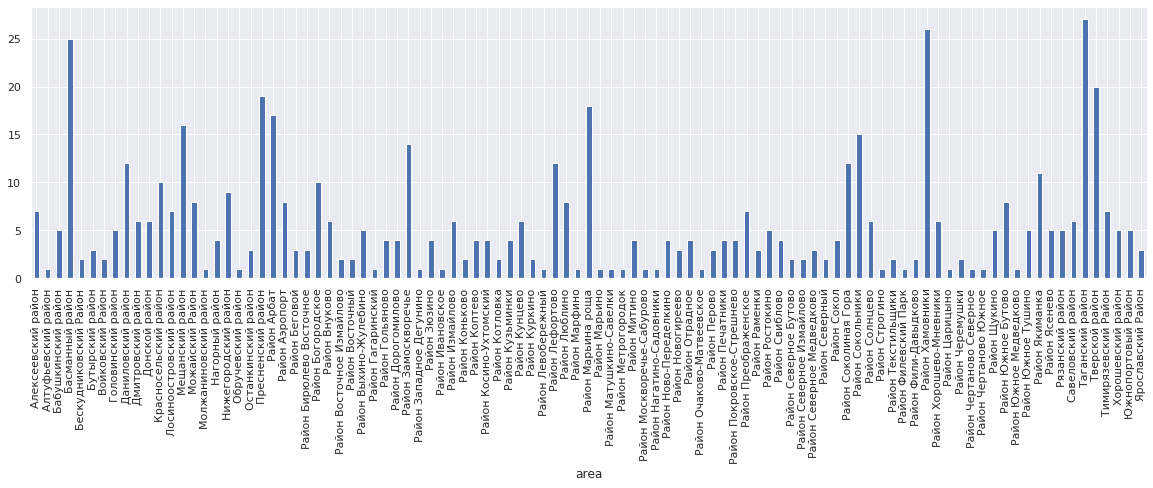

In [17]:
plt.xlabel = 'Количество улиц'
plt.ylabel = 'Район'
one_shop_str_merged.groupby('area').agg({'streetname': 'count'}).plot(kind = 'bar', figsize = (20, 5), legend = False)

Видим довольно много районов, в которых 5 и больше улиц с одним заведением питания.

### Распределение посадочных мест в заведениях топ-10 улиц

[Text(0, 0, 'Варшавское шоссе'),
 Text(0, 0, 'проспект Вернадского'),
 Text(0, 0, 'Кутузовский проспект'),
 Text(0, 0, 'Ленинградский проспект'),
 Text(0, 0, 'Ленинский проспект'),
 Text(0, 0, 'проспект Мира'),
 Text(0, 0, 'Профсоюзная улица'),
 Text(0, 0, 'город Зеленоград'),
 Text(0, 0, 'поселение Сосенское'),
 Text(0, 0, 'Пресненская набережная')]

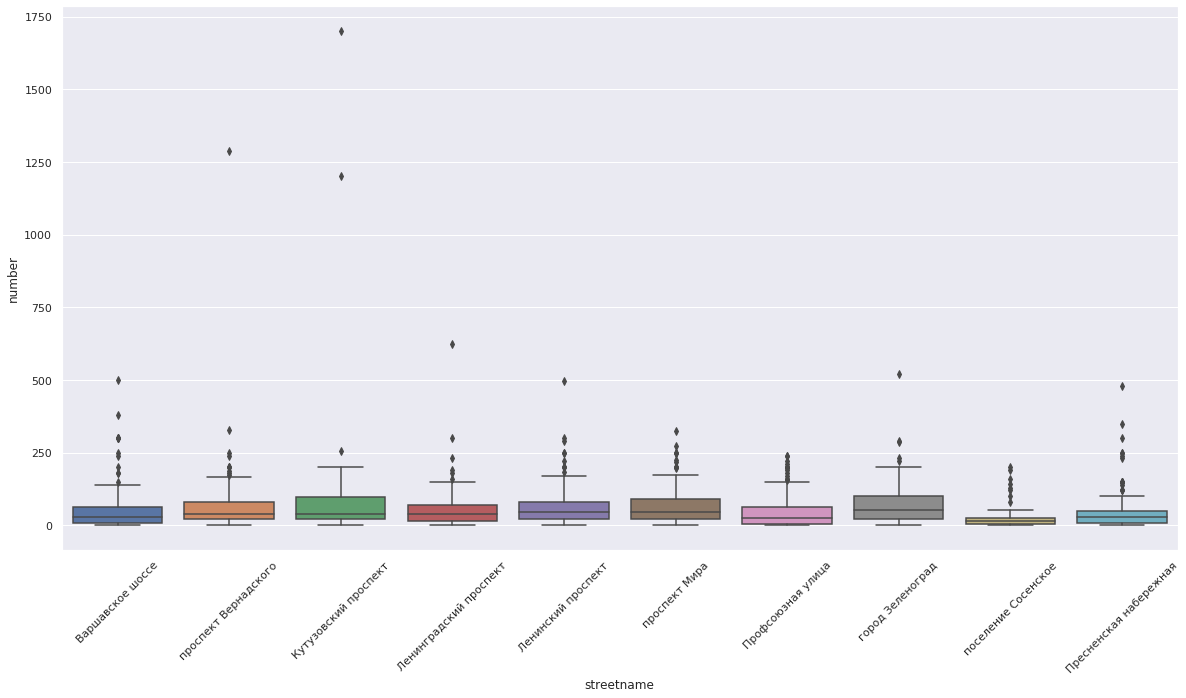

In [18]:
top_10_str_names = top_10_streets['streetname']
sns.set(rc = {'figure.figsize':(20,10)})
ax = sns.boxplot(x = 'streetname', y = 'number', data = data[['number', 'streetname']].query('streetname in @top_10_str_names'))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

Видно, что медианные значения количества посадочных мест в заведениях, расположенных на улицах из списка топ-10 примерно равны. Значительно меньше остальных этот показатель только на **Варшавском шоссе**, **Пресненской набережной** и в **поселении Сосенском**.

## Выводы

По итогам исследования можно сделать следующий вывод:
* Наиболее популярные типы заведений - кафе, столовые, рестораны и предприятия быстрого обслуживания;
* Распространенное количество посадочных мест в подобных заведениях - от 40 до 130;
* Выгодным расположением из популярных улиц можно назвать Варшавское шоссе, Пресненскую набережную и поселение Сосенское;
* Если рассматривать улицы с маленьким количеством заведений, необходимо провести дополнительное исследование и уточнить, с чем связана невысокая популярность мест - с низкой проходимостью или другими факторами. Возможно, при выборе менее популярного места удастся снизить расходы на аренду.

Презентация: https://drive.google.com/file/d/10n95XJ44wNOTWn90hObD25K3DusUH0Ps/view?usp=sharing